In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_dataset():
    dataset=pd.read_csv("Milk.csv",index_col='Month')
    dataset.index = pd.to_datetime(dataset.index)
    
    ratio=0.9
    train_dataset=dataset[0:int(len(dataset)*ratio)]
    test_dataset=dataset[int(len(dataset)*ratio)+1:]
    
    return train_dataset,test_dataset

In [3]:
train_dataset,test_dataset=load_dataset()
normalized_train_dataset=MinMaxScaler().fit_transform(train_dataset)
normalized_test_dataset=MinMaxScaler().fit_transform(test_dataset)
    

In [4]:
layer = {
    'input':1,
    'hidden':100,
    'output': 1
}
batch_size=2 #tiap epoch ambil berapa set
time_step=12 #setiap batch isinya ambil berapa set
epoch=1000
learning_rate=0.01

In [5]:
input_placeholder=tf.placeholder(tf.float32,[None, time_step,layer['input']])
output_placeholder=tf.placeholder(tf.float32,[None, time_step,layer['output']])

In [6]:
#cell construct + activation
cell=tf.nn.rnn_cell.BasicRNNCell(layer['hidden'], activation=tf.nn.relu)
cell=tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=layer['output'],activation=tf.nn.relu)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
output,_=tf.nn.dynamic_rnn(cell, input_placeholder, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss=tf.reduce_mean(0.5 * (output_placeholder-output) **2)
train=tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
saver=tf.train.Saver()

In [10]:
def get_batch(dataset,time_step,batch_size):
    input_batch=np.zeros(shape=(batch_size,time_step,layer['input']))
    output_batch=np.zeros(shape=(batch_size,time_step,layer['output']))
    for i in range (batch_size):
        point = np.random.randint(0,len(dataset)-time_step)
        
        input_batch[i]=dataset[point:point+time_step]
        output_batch[i]=dataset[point+1:point+time_step+1]
        
    return input_batch, output_batch

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoch+1):
        input_batch, output_batch=get_batch(normalized_train_dataset, time_step,batch_size)
        
        feed={
            input_placeholder:input_batch,
            output_placeholder:output_batch
        }
        
        sess.run(train,feed_dict=feed)
        if i%250 == 0:
            print('epoch:{},loss:{}'.format(i,sess.run(loss,feed_dict=feed)))
            
    saver.save(sess,"model/model2.ckpt")

epoch:0,loss:0.024622337892651558
epoch:250,loss:0.00467419670894742
epoch:500,loss:0.004126868676394224
epoch:750,loss:0.003071831539273262
epoch:1000,loss:0.0017167403129860759


INFO:tensorflow:Restoring parameters from model/model2.ckpt


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


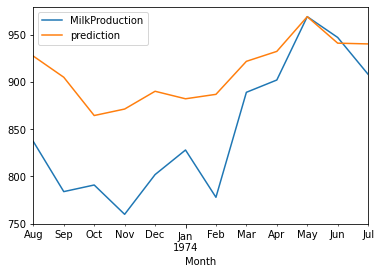

In [12]:
with tf.Session() as sess:
    saver.restore(sess,"model/model2.ckpt")
    
    listed_dataset = list(normalized_train_dataset)
    input_batch=np.array(listed_dataset[-time_step - 1:len(listed_dataset)-1]).reshape(1,time_step,layer['input'])
    
    feed={
        input_placeholder:input_batch
    }
    
    prediction=sess.run(output,feed_dict=feed)
    for i in range(time_step):
        listed_dataset.append(prediction[0,i,0])
        
prediction_calculation = np.array(listed_dataset[-time_step:]).reshape([1,time_step])
prediction_calculation = MinMaxScaler().fit(test_dataset).inverse_transform(prediction_calculation)

visualizer=train_dataset.tail(time_step)
visualizer['prediction']=prediction_calculation[0]

visualizer.plot()
plt.show()